In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# from fastcluster import linkage
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette, linkage
from scipy.cluster import hierarchy
from scipy.spatial import distance
from matplotlib.colors import rgb2hex, colorConverter
from collections import defaultdict, OrderedDict

# Create a random dataframe (can be a counts matrix, or expression matrix, or whatever)

In [2]:
df = pd.DataFrame(np.random.randint(0,100,size=(10, 10)), index=list('ABCDEFGHIJ'))
df

,0,1,2,3,4,5,6,7,8,9
A,60,14,73,28,73,93,82,93,37,72
B,6,86,22,66,1,81,88,79,49,44
C,7,41,76,89,37,46,12,1,97,26
D,42,89,91,15,35,10,61,67,85,19
E,18,75,49,58,74,58,40,1,18,55
F,98,45,18,56,7,49,30,7,98,80
G,96,45,80,1,8,61,55,76,77,43
H,67,22,12,60,86,16,62,89,23,87
I,40,94,39,48,89,89,40,8,83,14
J,54,97,88,50,47,14,9,44,25,15


# Calculate the average among all columns in a pandas DataFrame.

In [3]:
#def get_avg(lst):
#    return sum(lst) / len(lst) 

def get_avg(df, col_list):
    """
    Given a dataframe (df) and two columns (col_list), return the average
    """
    return df[col_list].mean(axis=1)

def group_every(n, lst):
    """
    Groups a list of columns into even groups of size n
    """
    groups = []
    group = []
    
    assert len(lst) % n == 0 # we want to make sure the numbers are evenly grouped.

    i = 1 # local counter
    while i <= len(lst):
        group.append(lst[i-1])
        if i % n == 0 and i != 0:
            groups.append(group)
            group = []
        i += 1
    return groups

def format_colname(col_list):
    """
    Nicer string-representation of a list of columns
    """
    return "_".join(str(col_list).strip("[]").split(", "))
    
def transform_avg_df(df, n):
    """
    computes the average (every n columns) of a dataframe containing values
    """
    transformed = OrderedDict()
    grouped_columns = group_every(n, df.columns)
    for grouped_column in grouped_columns:
        transformed[format_colname(grouped_column)] = get_avg(df, grouped_column)
    return pd.DataFrame(transformed)

## Sanity check, transform the dataframe to compute the average of every (1) column. Should be the same (minus the int -> float typechange) as the original.

In [4]:
transform_avg_df(df, 1) # 

,0,1,2,3,4,5,6,7,8,9
A,60.0,14.0,73.0,28.0,73.0,93.0,82.0,93.0,37.0,72.0
B,6.0,86.0,22.0,66.0,1.0,81.0,88.0,79.0,49.0,44.0
C,7.0,41.0,76.0,89.0,37.0,46.0,12.0,1.0,97.0,26.0
D,42.0,89.0,91.0,15.0,35.0,10.0,61.0,67.0,85.0,19.0
E,18.0,75.0,49.0,58.0,74.0,58.0,40.0,1.0,18.0,55.0
F,98.0,45.0,18.0,56.0,7.0,49.0,30.0,7.0,98.0,80.0
G,96.0,45.0,80.0,1.0,8.0,61.0,55.0,76.0,77.0,43.0
H,67.0,22.0,12.0,60.0,86.0,16.0,62.0,89.0,23.0,87.0
I,40.0,94.0,39.0,48.0,89.0,89.0,40.0,8.0,83.0,14.0
J,54.0,97.0,88.0,50.0,47.0,14.0,9.0,44.0,25.0,15.0


## Transform the dataframe to compute the average of every (n) columns. Should contain the average of every (2) columns.

In [5]:
transform_avg_df(df, 2) # 

,0_1,2_3,4_5,6_7,8_9
A,37.0,50.5,83.0,87.5,54.5
B,46.0,44.0,41.0,83.5,46.5
C,24.0,82.5,41.5,6.5,61.5
D,65.5,53.0,22.5,64.0,52.0
E,46.5,53.5,66.0,20.5,36.5
F,71.5,37.0,28.0,18.5,89.0
G,70.5,40.5,34.5,65.5,60.0
H,44.5,36.0,51.0,75.5,55.0
I,67.0,43.5,89.0,24.0,48.5
J,75.5,69.0,30.5,26.5,20.0


# Very large example:

In [6]:
df = pd.DataFrame(np.random.randint(0,100000,size=(1000, 1000)), index=list(range(1000)))

In [7]:
%%timeit
dx = transform_avg_df(df, 5)

196 ms ± 4.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Plot heatmap using seaborn

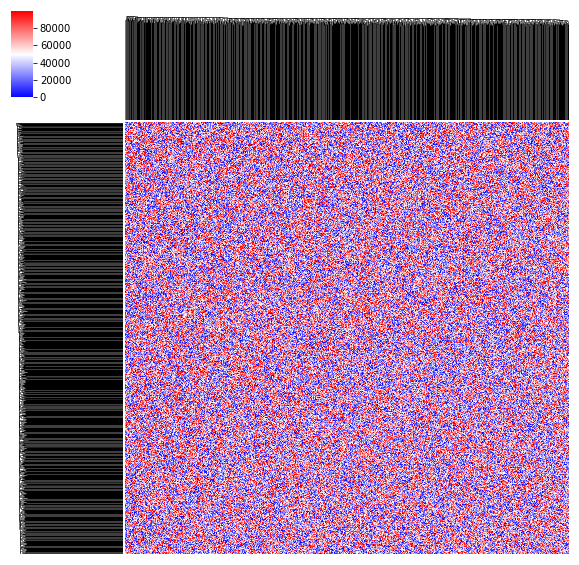

In [8]:
# If we have more than 100 values, dont plot the tick labels (otherwise will be time consuming!)
print_yticklabels = False if df.shape[0] > 100 else True
print_xticklabels = False if df.shape[1] > 100 else True

cg = sns.clustermap(
    df, 
    xticklabels=print_yticklabels, 
    yticklabels=print_xticklabels, 
    figsize=(10, 10),
    metric='euclidean',
    method='average', 
    edgecolors='white', 
    linewidths=0.000,
    cmap='bwr'
)

# Plot heatmap and cluster separately:

In [9]:
class Clusters(dict):
    """
    Converts rgb values to hex for viewing.
    In reality I don't need this and can just use a dict, but
    useful for viewing stuff.
    """

    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
                    '<td style="background-color: {0}; ' \
                    'border: 0;">' \
                    '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>'
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html


def get_cluster_classes(den, label='ivl'):
    """
    Appends gene names to their corresponding cluster ids
    """
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes


def get_row_linkage(df, metric, method, colors_to_use):
    """
    Returns the linkage given the distance metric and method
    """
    hierarchy.set_link_color_palette(
        colors_to_use
    )
    row_linkage = hierarchy.linkage(
        distance.pdist(
            df, 
            metric=metric
        ),
        method=method,
        metric=metric,
        optimal_ordering=True,
    )
    return row_linkage

def get_dendrogram(df, row_linkage, leaf_height):
    """
    Plots a dendrogram and returns the values for incorporation into the main plot.
    """
    fig, ax = plt.subplots(figsize=(75,15)) # make this really big so we can see each leaf

    den = dendrogram(
        row_linkage, labels=df.index,
        color_threshold=leaf_height,
        no_plot=False,
        above_threshold_color='grey', # any singleton below the leaf cutoff will be grey (uncategorized)
    )
    ax.axhline(leaf_height, alpha=0.75)
    return den

def get_sidebar_colors(df, leaf_height, metric, method, colors_to_use):
    """
    First calculates the linkage and dendrogram values, then
    gets clusters and the row colors from the cluster ids
    """
    row_colors = pd.DataFrame(index=df.index)
    row_linkage = get_row_linkage(
        df, 
        metric=metric, 
        method=method,
        colors_to_use=colors_to_use
    )
    den = get_dendrogram(
        df, 
        row_linkage, 
        leaf_height
    )
    row_colors['Cluster'] = 'White' # initialize with some variable
    clusters = get_cluster_classes(den)

    for key in clusters.keys():
        for gene in get_cluster_classes(den)[key]:
            row_colors.loc[gene]['Cluster'] = key

    return clusters, row_colors

# Note: You may need to look at the dendrogram and determine the appropriate leaf height/number of clusters to show. If the number of colors is smaller than the number of clusters determined by the dendrogram leaf cutoff (leaf height), there will be a recycling of colors.

grey,"[13, 72, 37, 15, 92, 42, 24, 46, 60, 28, 10, 35, 74, 96, 36, 57, 97, 99, 17, 12, 19, 67, 89, 79, 58, 53, 51, 39, 20, 77, 9, 47, 91, 52, 64, 59, 69, 88, 49, 29, 70, 48, 1, 93, 80, 56, 85, 82, 94, 22, 25, 86, 38, 62, 40, 87, 71, 27, 50, 41, 98, 31, 54, 45, 61, 0, 16, 34, 81, 84]"
#db5f57,"[2, 26]"
#db7e57,"[90, 23]"
#db9e57,"[5, 6]"
#dbbe57,"[73, 18]"
#d9db57,"[68, 8]"
#b9db57,"[32, 4]"
#99db57,"[85, 95]"
#79db57,"[100, 83]"
#59db57,"[11, 33, 43]"
#57db74,"[21, 3]"


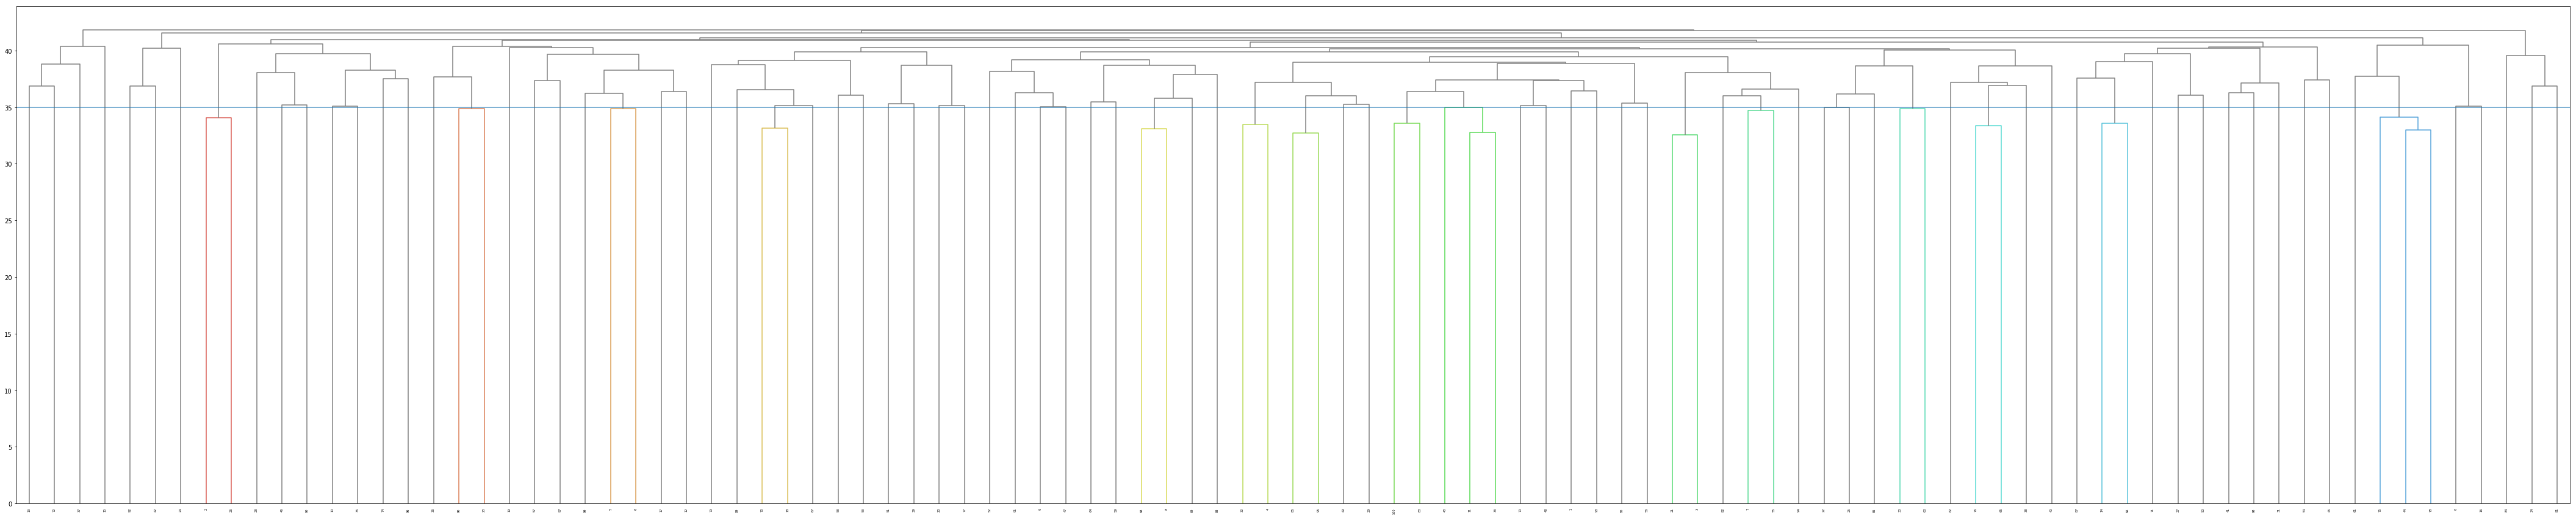

In [10]:
leaf_height = 35  # This controls the "cutoff" by which the dendrogram defines each cluster. 
num_clusters = 25 # This controls the number of clusters 
colors_to_use = [str(x) for x in sns.color_palette('hls', num_clusters).as_hex()]
metric = "euclidean"
method = "average"

df = pd.DataFrame(np.random.randint(0,10,size=(101, 101)), index=list(range(101)))

clusters, row_colors = get_sidebar_colors(
    df, 
    metric=metric, 
    method=method,
    leaf_height=leaf_height, 
    colors_to_use=colors_to_use
)
clusters # prints the corresponding cluster color for each row ID.

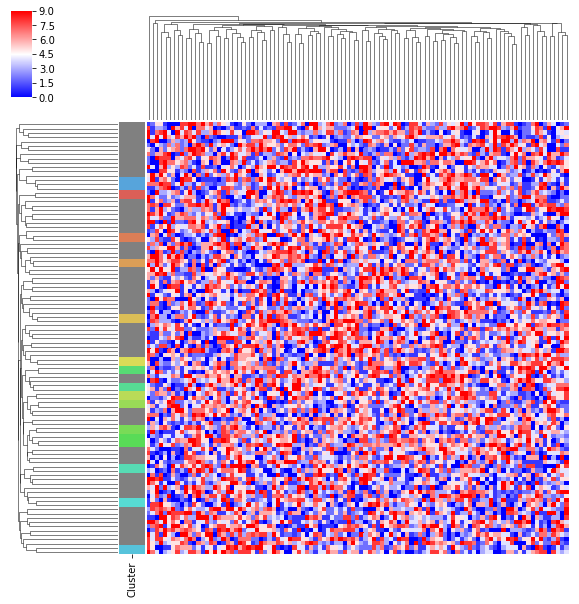

In [11]:
# If we have more than 100 values, dont plot the tick labels (otherwise will be time consuming!)
print_yticklabels = False if df.shape[0] > 100 else True
print_xticklabels = False if df.shape[1] > 100 else True

cg = sns.clustermap(
    df, 
    xticklabels=print_yticklabels, 
    yticklabels=print_xticklabels, 
    figsize=(10, 10),
    metric='euclidean',
    method='average', 
    edgecolors='white', 
    linewidths=0.000,
    cmap='bwr',
    row_colors=row_colors,
)

# Plot a heatmap without clustering
- This is the fastest way to plot a heatmap (using pcolorfast)

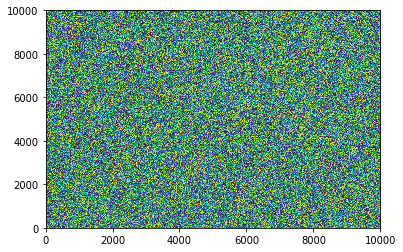

In [12]:
fig, ax = plt.subplots()
df = pd.DataFrame(np.random.randint(0,100000,size=(10000, 10000)), index=list(range(10000)))
ax.pcolorfast(df)